In [1]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from utils.utils_embedding import evaluate, dataframe_results, plot_embeddings, create_set_embeddings, load_qa_dataset
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sentence_transformers import util

/opt/homebrew/Caskroom/miniconda/base/envs/agent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
top_k = 3
dataset_name = "QA/gpt-35-turbo_dataset.json"
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
num_pca_componets = 2
num_epochs = 2
finetuned_filename = "finetuned_model"

In [3]:
it_dataset = load_qa_dataset(dataset_name)

2025-07-15 21:24:29.793 | INFO     | utils.utils_embedding:load_qa_dataset:15 - Loading dataset from QA/gpt-35-turbo_dataset.json


In [4]:
embed_model_paraphrase_l12 = HuggingFaceEmbedding(model_name=model_name)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


In [5]:
df_no_finetuned_results_it = evaluate(dataset=it_dataset, 
                                        embed_model=embed_model_paraphrase_l12, 
                                        top_k=top_k, 
                                        verbose=True)
print(len(df_no_finetuned_results_it))
df_no_finetuned_results_it.tail(10)

Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:04<00:00, 62.22it/s]

260


,is_hit,mrr,retrieved,expected,query
250,False,0.0,"[56711f78-5068-4c5b-aa14-24c8e74d867c, e7e2678...",b4b510a8-750c-4400-8b41-eac75fb45b36,97bdf203-6778-49ec-ad65-7314d7bec4dd
251,True,1.0,"[730202dc-b88d-474c-8095-ad658246d7f8, c50d973...",730202dc-b88d-474c-8095-ad658246d7f8,83b823e8-a411-4fb9-a059-ce95b4565248
252,True,1.0,"[054787bf-6ea2-45cb-b63c-afc92f2130e7, 80515a8...",054787bf-6ea2-45cb-b63c-afc92f2130e7,de8a901b-0676-4da0-8621-c67b6da619b2
253,False,0.0,"[ca82b433-2650-44ca-9764-6f627f7e1a3e, 752074a...",76404184-b979-4e78-981b-f46d4856659a,1655df78-4a12-42df-86d3-63aa95cbd8cc
254,False,0.0,"[ca82b433-2650-44ca-9764-6f627f7e1a3e, e96386a...",c0f65694-d0fd-42d7-8445-ec6af48c6ca5,9d17b425-7c88-474e-8218-549b8d9c21b4
255,False,0.0,"[ca82b433-2650-44ca-9764-6f627f7e1a3e, 752074a...",e3739cd7-9497-4a02-879a-8d4dca5e17d3,6ea83306-88c1-46f1-a35d-a0a96638d819
256,True,1.0,"[49633b5f-3c9e-40bd-a7e0-19c25ac4e69d, 249f5ff...",49633b5f-3c9e-40bd-a7e0-19c25ac4e69d,a15bb0f4-098c-4cff-90f5-2d46c838316b
257,False,0.0,"[054787bf-6ea2-45cb-b63c-afc92f2130e7, e96386a...",c3eb51b9-9c82-46bc-b00e-eb0cdd88b9c3,1c0518f1-5267-4da5-9e09-ddb2736c2cc7
258,False,0.0,"[c3beb6ea-6bfc-4bbd-a6ad-4944bf5d4295, 1c56c4c...",b6416b83-c994-461b-9a70-d1edfa85fb3e,172eb881-cbf3-44b6-92ed-442b9e7b34de
259,True,1.0,"[c50d973a-035f-4b79-93ec-cd955b2f99c4, 56711f7...",c50d973a-035f-4b79-93ec-cd955b2f99c4,38fdf813-8188-4e4d-bd44-4ca848a577fa


In [6]:
pca = PCA(n_components=num_pca_componets)
array_embeddings_paraphrase_l12_it = create_set_embeddings(it_dataset, embed_model_paraphrase_l12)
projected = pca.fit_transform(array_embeddings_paraphrase_l12_it)

100%|██████████| 260/260 [00:04<00:00, 64.42it/s]


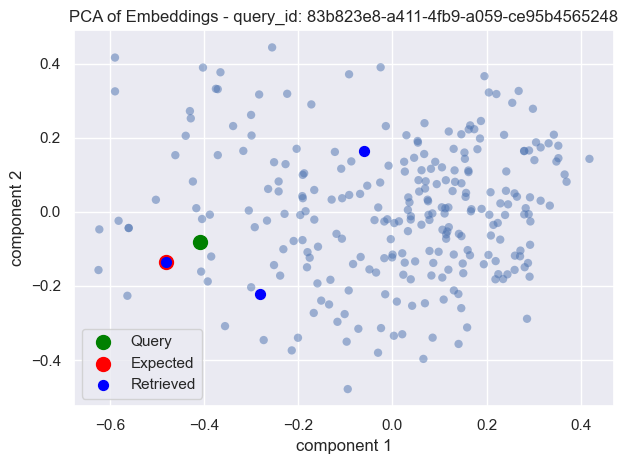

2025-07-15 21:24:43.396 | INFO     | __main__:<module>:18 - Mean cosine similarity between query and retrieved embeddings: 0.6252


In [7]:
from loguru import logger

query_id = '83b823e8-a411-4fb9-a059-ce95b4565248'

unmatch_query = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["query"].values[0]
unmatch_expected = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["expected"].values[0]
unmatch_retrieved = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["retrieved"].values[0]

query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries[unmatch_query])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus[unmatch_expected])
list_retrieved_embedding = []
for i, retrieved in enumerate(unmatch_retrieved):
    list_retrieved_embedding.append(embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus[retrieved]))

plot_embeddings(pca, query_id, projected, query_embedding, expected_embedding, list_retrieved_embedding, filename="imgs/embeddings_pca_no_finetune_1.png")

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

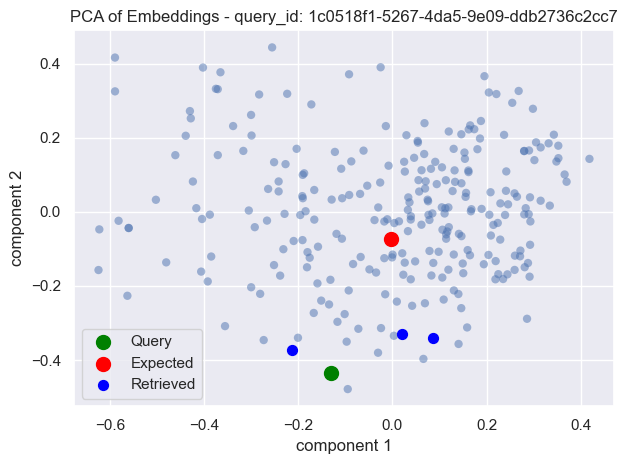

2025-07-15 21:24:43.569 | INFO     | __main__:<module>:17 - Mean cosine similarity between query and retrieved embeddings: 0.7465


In [8]:
query_id = '1c0518f1-5267-4da5-9e09-ddb2736c2cc7'

unmatch_query = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["query"].values[0]
unmatch_expected = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["expected"].values[0]
unmatch_retrieved = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["retrieved"].values[0]

query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries[unmatch_query])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus[unmatch_expected])

list_retrieved_embedding = []
for i, retrieved in enumerate(unmatch_retrieved):
    list_retrieved_embedding.append(embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus[retrieved]))

plot_embeddings(pca, query_id, projected, query_embedding, expected_embedding, list_retrieved_embedding, filename="imgs/embeddings_pca_no_finetune_2.png")

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

In [9]:
from llama_index.finetuning import SentenceTransformersFinetuneEngine

finetune_engine = SentenceTransformersFinetuneEngine(
                                                    it_dataset,
                                                    model_id=model_name,
                                                    model_output_path=finetuned_filename,
                                                    val_dataset=it_dataset,
                                                    epochs=num_epochs
                                                    )

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


In [10]:
finetune_engine.finetune()
finetuned_embed_model = finetune_engine.get_finetuned_model()

/opt/homebrew/Caskroom/miniconda/base/envs/agent/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
26,No log,No log,0.600000,0.742308,0.796154,0.830769,0.600000,0.247436,0.159231,0.083077,0.600000,0.742308,0.796154,0.830769,0.718635,0.682344,0.686095
50,No log,No log,0.607692,0.769231,0.819231,0.850000,0.607692,0.256410,0.163846,0.085000,0.607692,0.769231,0.819231,0.850000,0.733621,0.695667,0.700110
52,No log,No log,0.611538,0.769231,0.823077,0.850000,0.611538,0.256410,0.164615,0.085000,0.611538,0.769231,0.823077,0.850000,0.735158,0.697718,0.702163


INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Information Retrieval Evaluation of the model on the  dataset in epoch 1.0 after 26 steps:
Information Retrieval Evaluation of the model on the  dataset in epoch 1.0 after 26 steps:
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Queries: 260
Queries: 260
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Corpus: 260

Corpus: 260

INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Score-Function: cosine
Score-Function: cosine
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@1: 60.00%
Accuracy@1: 60.00%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@3: 74.23%
Accuracy@3: 74.23%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@5: 79.62%
Accuracy@5: 79.62%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@10: 83.08%
Accuracy@10: 83.08%
INFO:sentence_transfor

In [11]:
#from llama_index.core.embeddings.utils import resolve_embed_model
#from llama_index.embeddings.adapter import AdapterEmbeddingModel
#base_embed_model = resolve_embed_model(embed_model_paraphrase_l12)
#embed_model = AdapterEmbeddingModel(base_embed_model, adapter_path=finetuned_filename)

In [12]:
df_finetuned_results_it = evaluate(dataset=it_dataset, 
                                        embed_model=finetuned_embed_model,
                                        top_k=top_k, 
                                        verbose=True)
print(len(df_finetuned_results_it))
df_finetuned_results_it.head()

Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 73.33it/s]

260


,is_hit,mrr,retrieved,expected,query
0,True,1.0,"[80b9998c-32d4-42f7-94a7-1a36155b382b, f87cb75...",80b9998c-32d4-42f7-94a7-1a36155b382b,6c67a361-1d84-4876-8ed5-72e11dd2f21e
1,False,0.0,"[e81fb935-4ea8-4a80-867d-ed15f40d0a0c, 0ddb84a...",93b772d4-52a6-44a6-a331-0eae1fdf33a5,5377179f-f310-4498-9a81-4a644d21eef6
2,True,1.0,"[f612986a-0b1a-4c12-bdf1-2c2107733db7, b4b510a...",f612986a-0b1a-4c12-bdf1-2c2107733db7,a980095d-5cd4-4112-9b80-d3d1e7023f44
3,True,1.0,"[b87e8ec1-9380-48ad-9428-47c47ede0e76, c0f6569...",b87e8ec1-9380-48ad-9428-47c47ede0e76,364684a1-eafa-4081-ba35-bb669d1657b7
4,True,0.5,"[e96386a3-3796-457d-875e-2d6c7bdab02f, 4a5026b...",4a5026bd-2856-497f-8276-9de39b7562e6,2356fbfa-7df2-467d-ac72-ef26ed474fff


In [ ]:
array_embeddings_paraphrase_l12_it = create_set_embeddings(it_dataset, embed_model_paraphrase_l12)
projected = pca.fit_transform(array_embeddings_paraphrase_l12_it)

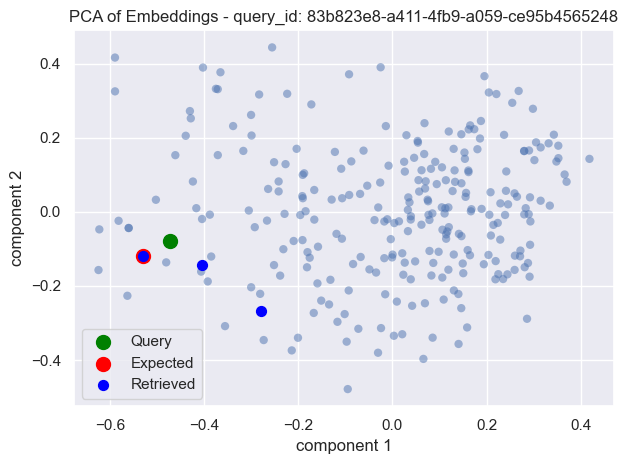

2025-07-15 21:25:17.672 | INFO     | __main__:<module>:16 - Mean cosine similarity between query and retrieved embeddings: 0.6505


In [13]:
query_id = '83b823e8-a411-4fb9-a059-ce95b4565248'
unmatch_query = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["query"].values[0]
unmatch_expected = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["expected"].values[0]
unmatch_retrieved = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["retrieved"].values[0]

query_embedding = finetuned_embed_model.get_text_embedding(it_dataset.queries[unmatch_query])
expected_embedding = finetuned_embed_model.get_text_embedding(it_dataset.corpus[unmatch_expected])

list_retrieved_embedding = []
for i, retrieved in enumerate(unmatch_retrieved):
    list_retrieved_embedding.append(finetuned_embed_model.get_text_embedding(it_dataset.corpus[retrieved]))

plot_embeddings(pca, query_id, projected, query_embedding, expected_embedding, list_retrieved_embedding, filename="imgs/embeddings_pca_finetune_1.png")

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

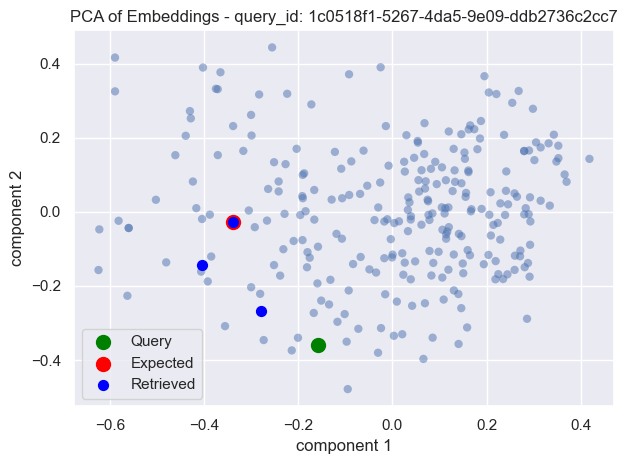

2025-07-15 21:25:17.879 | INFO     | __main__:<module>:17 - Mean cosine similarity between query and retrieved embeddings: 0.6544


In [14]:
query_id = '1c0518f1-5267-4da5-9e09-ddb2736c2cc7'

unmatch_query = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["query"].values[0]
unmatch_expected = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["expected"].values[0]
unmatch_retrieved = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["retrieved"].values[0]

query_embedding = finetuned_embed_model.get_text_embedding(it_dataset.queries[unmatch_query])
expected_embedding = finetuned_embed_model.get_text_embedding(it_dataset.corpus[unmatch_expected])

list_retrieved_embedding = []
for i, retrieved in enumerate(unmatch_retrieved):
    list_retrieved_embedding.append(finetuned_embed_model.get_text_embedding(it_dataset.corpus[retrieved]))

plot_embeddings(pca, query_id, projected, query_embedding, expected_embedding, list_retrieved_embedding, filename="imgs/embeddings_pca_finetune_2.png")

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")